# Time Series Forecast with Prophet

## Introduction:
This is a simple kernel in which we will forecast stock prices using Prophet (Facebook's library for time series forecasting). However, historical prices are no indication whether a price will go up or down.  I'll rather use my own variables and use machine learning for stock price prediction rather than just using historical prices as an indication of stock price increase.


## A Summary about Prophet:
Facebook's research team has come up with an easier implementation of forecasting through it's new library called Prophet. From what I have read, the blog state's that analyst that can produce high quality forecasting data is rarely seen. This is one of the reasons why Facebook's research team came to an easily approachable way for using advanced concepts for time series forecasting and us Python users, can easily relate to this library since it uses Scikit-Learn's api (Similar to Scikit-Learn). To gain further information, you can look at  [Prophet Blog](https://research.fb.com/prophet-forecasting-at-scale/). Prophet's team main goal is to <b>to make it easier for experts and non-experts to make high quality forecasts that keep up with demand. </b> <br><br>

There are several characteristics of Prophet (you can see it in the blog) that I want to share with you Kaggles that shows where Prophet works best:
<ul>
<li>hourly, daily, or weekly observations with at least a few months (preferably a year) of history </li>
<li>strong multiple “human-scale” seasonalities: day of week and time of year </li>
<li>Important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl) </li>
<li>A reasonable number of missing observations or large outliers </li>
<li>Historical trend changes, for instance due to product launches or logging changes </li>
<li>Trends that are non-linear growth curves, where a trend hits a natural limit or saturates </li>
</ul>
<br><br>

In [1]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet
# Statsmodels widely known for forecasting than Prophet
import statsmodels.api as sm
from scipy import stats
from pandas.core import datetools
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



In [2]:
df = pd.read_csv('../input/all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
# Brief Description of our dataset
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [4]:
# Replace the column name from name to ticks
df = df.rename(columns={'Name': 'Ticks'})

For this simple tutorial we will analyze Amazon's stock and see what will the trend look like for the nearby future of this stock relying on past stock prices.

In [5]:
# Let's analyze some of the stocks.
amzn = df.loc[df['Ticks'] == 'AMZN']
amzn.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


We need to make sure if the date column is either a categorical type or a datetype. In our case date is a categorical datatype so we need to change it to datetime.

In [6]:
amzn.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
date      1259 non-null object
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
close     1259 non-null float64
volume    1259 non-null int64
Ticks     1259 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 78.7+ KB


In [7]:
#  Change to dateformat
amzn.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [8]:
# Create a copy to avoid the SettingWarning .loc issue 
amzn_df = amzn.copy()
# Change to datetime datatype.
amzn_df.loc[:, 'date'] = pd.to_datetime(amzn.loc[:,'date'], format="%Y/%m/%d")

In [9]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 7 columns):
date      1259 non-null datetime64[ns]
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
close     1259 non-null float64
volume    1259 non-null int64
Ticks     1259 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


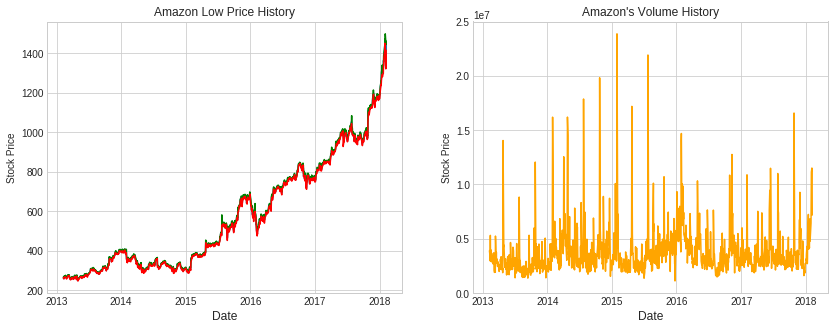

In [10]:
# Simple plotting of Amazon Stock Price
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(amzn_df["date"], amzn_df["close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon Close Price History")

# Second Subplot
ax1.plot(amzn_df["date"], amzn_df["high"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon High Price History")

# Third Subplot
ax1.plot(amzn_df["date"], amzn_df["low"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Amazon Low Price History")

# Fourth Subplot
ax2.plot(amzn_df["date"], amzn_df["volume"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Amazon's Volume History")
plt.show()

### Prophet Introduction:
Prophet is Facebook's library for time series forecasting. In my opinion, Prophet works best with datasets that are higely influenced by seasonality (electricity bills, restaurant visitors etc.) However, I wanted to show the simplicity of using Prophet for simple forecasting which is the main aim of this kernel.

#### Steps for using Prophet:
<ul>
<li>Make sure you replace closing price for y and date for ds. </li>
<li>Fit that dataframe to Prophet in order to detect future patterns. </li>
<li>Predict the upper and lower prices of the closing price. </li>
</ul>

In [11]:
m = Prophet()

# Drop the columns
ph_df = amzn_df.drop(['open', 'high', 'low','volume', 'Ticks'], axis=1)
ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

ph_df.head()

,ds,y
46387,2013-02-08,261.95
46388,2013-02-11,257.21
46389,2013-02-12,258.70
46390,2013-02-13,269.47
46391,2013-02-14,269.24


In [12]:
m = Prophet()

m.fit(ph_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1619,2019-02-03,1781.613591,1254.063633,2308.987142
1620,2019-02-04,1756.431956,1222.744826,2279.281611
1621,2019-02-05,1756.341465,1218.217537,2284.546054
1622,2019-02-06,1756.155910,1237.218681,2287.546663
1623,2019-02-07,1755.620316,1212.044511,2303.133141


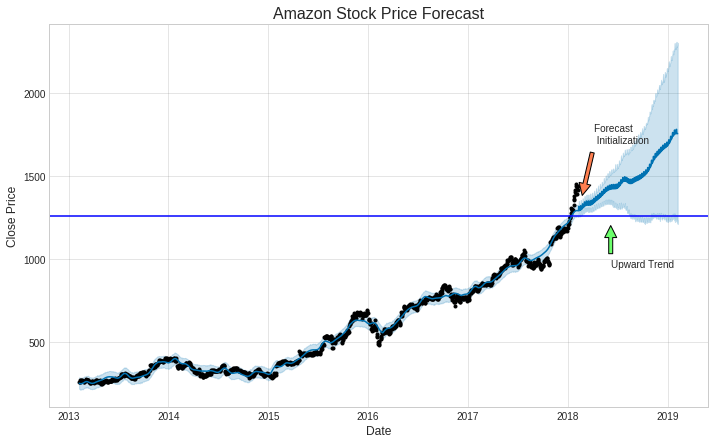

In [14]:
import matplotlib.dates as mdates

# Dates
starting_date = dt.datetime(2018, 4, 7)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2018, 6, 7)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 2, 18)
pointing_arrow1 = mdates.date2num(pointing_arrow)

# Learn more Prophet tomorrow and plot the forecast for amazon.
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("Amazon Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

# Forecast initialization arrow
ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 1350), xytext=(starting_date1,1700),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

# Trend emphasis arrow
ax1.annotate('Upward Trend', xy=(trend_date1, 1225), xytext=(trend_date1,950),
            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
            )

ax1.axhline(y=1260, color='b', linestyle='-')

plt.show()

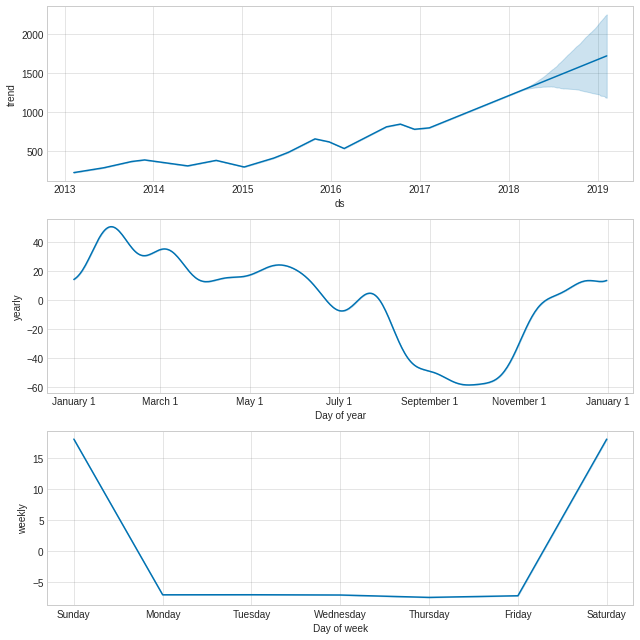

In [15]:
fig2 = m.plot_components(forecast)
plt.show()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


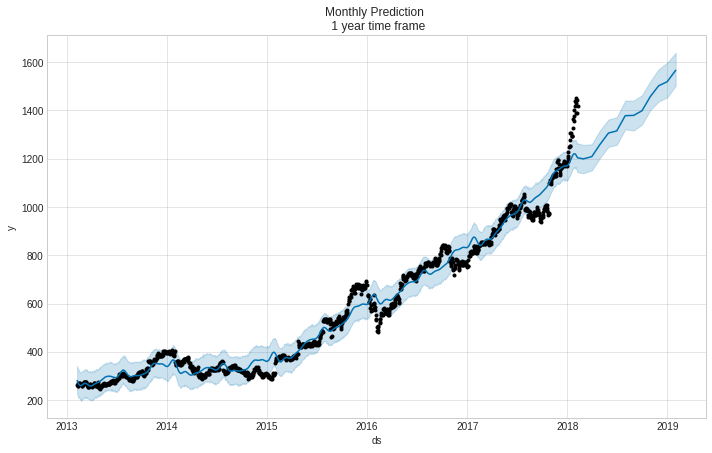

In [16]:
# Monthly Data Predictions
m = Prophet(changepoint_prior_scale=0.01).fit(ph_df)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title("Monthly Prediction \n 1 year time frame")

plt.show()

#### Trends:
<ul> 
<li>Amazon's stock price is showing signs of upper trend yearly. </li>
<li> Amazon's stock price show upper trend signs during January (December Sales tend to give a boost to Amazon's stock price)</li>
<li>There is no weekly trend for stock prices. </li>
</ul>

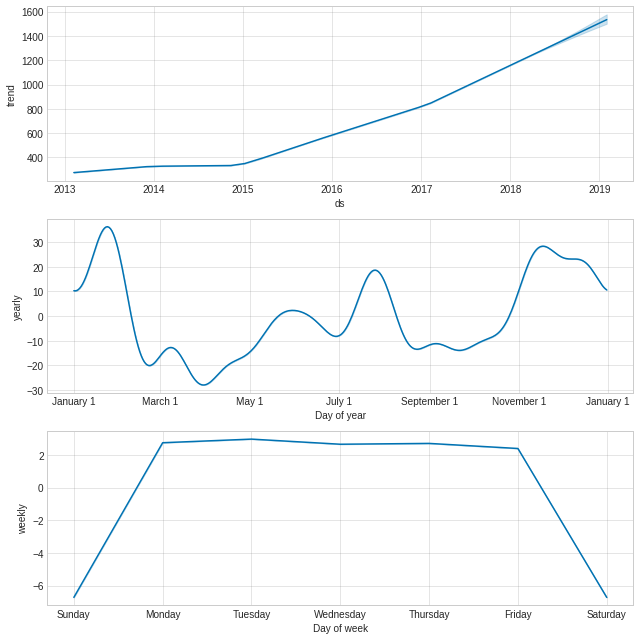

In [17]:
fig = m.plot_components(fcst)
plt.show()

<h2>Technical Analysis: </h2>
In this section we will go into basic technical concepts when dealing with stock investing. This are simple theories however, we shouldn't solely rely on these concepts to maximize profits as it is the case with patterns related to moving averages. Before going into this concepts, I will like to show how OHLC and Candlesticks are interpreted.

<h3 align="center">Open High Low Close (OHLC): </h3>
<img src="https://image.slidesharecdn.com/forexcandlestick-151105160826-lva1-app6892/95/forex-candlestick-5-638.jpg?cb=1446739926" ></img>
<br><br>
<h3 align="center">CandleSticks: </h3>
<img src="http://wealthv.com/learn/actionforex/images/candlestick_charts_explained_1.gif" ></img>
<br><br>
<h3 align="center">Moving Averages: </h3>
<img src="https://commodity.com/wp-content/uploads/technical-analysis/MASimple50200SPY.gif" ></img>

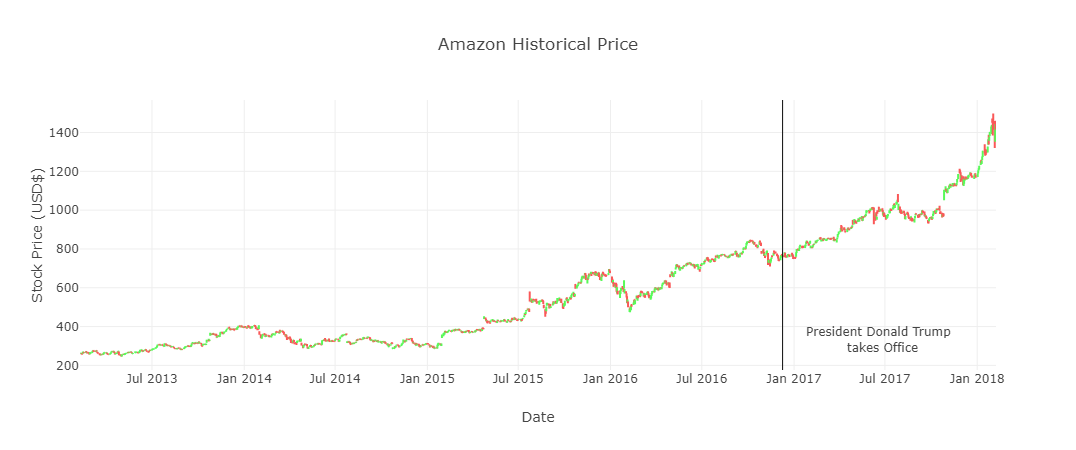

In [18]:
trace = go.Ohlc(x=amzn_df['date'],
                open=amzn_df['open'],
                high=amzn_df['high'],
                low=amzn_df['low'],
                close=amzn_df['close'],
               increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': 'Amazon Historical Price',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2016-12-09', 'x1': '2016-12-09',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2017-01-20', 'y': 0.05, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': 'President Donald Trump <br> takes Office'
    }]
}

data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

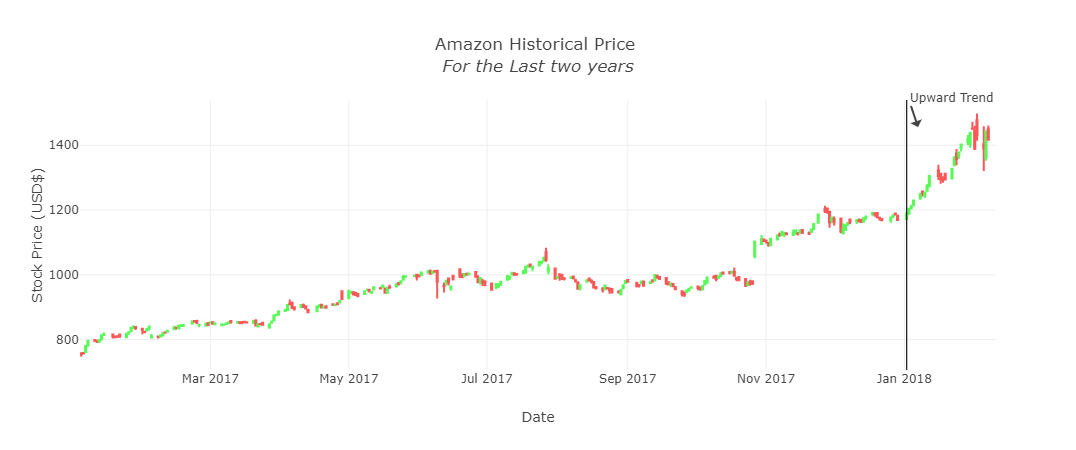

In [19]:
last_two = amzn_df.loc[amzn_df['date'].dt.year > 2016]

g = last_two.groupby(["date"])
monthly_averages = g.aggregate({"open": np.mean, "high": np.mean, "low": np.mean, "close":np.mean})
monthly_averages.reset_index(level=0, inplace=True)

trace = go.Candlestick(x=monthly_averages['date'],
                       open=monthly_averages['open'].values.tolist(),
                       high=monthly_averages['high'].values.tolist(),
                       low=monthly_averages['low'].values.tolist(),
                       close=monthly_averages['close'].values.tolist(),
                      increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': 'Amazon Historical Price <br> <i>For the Last two years </i>',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2018-01-02', 'x1': '2018-01-02',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2018-01-07', 'y': 0.9, 'xref': 'x', 'yref': 'paper',
        'showarrow': True, 'xanchor': 'left',
        'text': 'Upward Trend'
    }]
}


data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

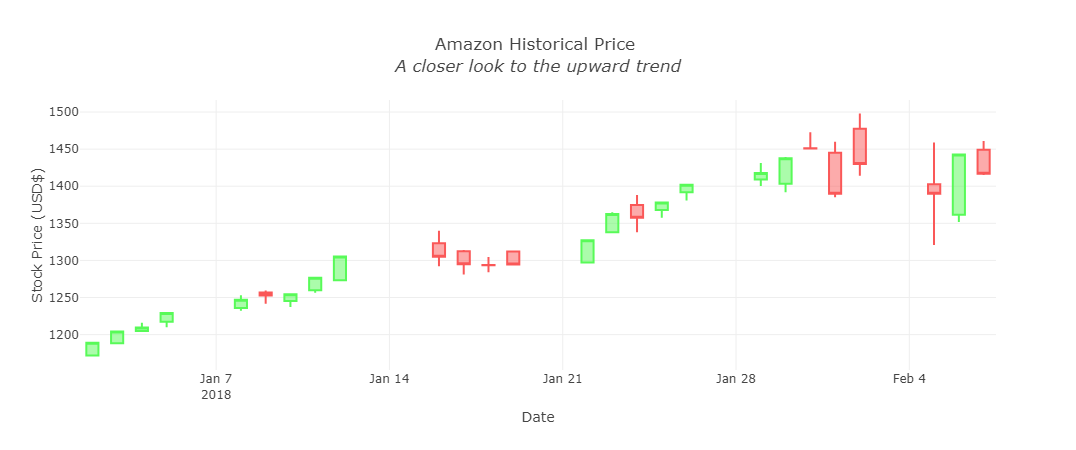

In [20]:
amzn_df['month_year'] = pd.to_datetime(amzn_df['date']).dt.to_period('M')

# 2017 onwards
last_year = amzn_df.loc[amzn_df['date'].dt.year > 2017]
g = last_year.groupby(["date"])
monthly_averages = g.aggregate({"open": np.mean, "high": np.mean, "low": np.mean, "close":np.mean})
monthly_averages.reset_index(level=0, inplace=True)

monthly_averages.dtypes


trace = go.Candlestick(x=monthly_averages['date'],
                       open=monthly_averages['open'].values.tolist(),
                       high=monthly_averages['high'].values.tolist(),
                       low=monthly_averages['low'].values.tolist(),
                       close=monthly_averages['close'].values.tolist(),
                      increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))


layout = {
    'title': 'Amazon Historical Price <br> <i>A closer look to the upward trend </i>',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'}
}


data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

In [21]:
amzn_df.head()

,date,open,high,low,close,volume,Ticks,month_year
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN,2013-02
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN,2013-02
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN,2013-02
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN,2013-02
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN,2013-02


In [22]:
# Moving Averages (10, 50 and 200)
amzn_df['10_d_avg'] = amzn_df.close.rolling(window=10).mean()
amzn_df['50_d_avg'] = amzn_df.close.rolling(window=50).mean()
amzn_df['200_d_avg'] = amzn_df.close.rolling(window=200).mean()
close_p = amzn_df['close'].values.tolist()


# Variables to insert into plotly
ten_d = amzn_df['10_d_avg'].values.tolist()
fifty_d = amzn_df['50_d_avg'].values.tolist()
twoh_d = amzn_df['200_d_avg'].values.tolist()
date = amzn_df['date'].values.tolist()

# Set date as index
amzn_df = amzn_df.set_index('date')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]



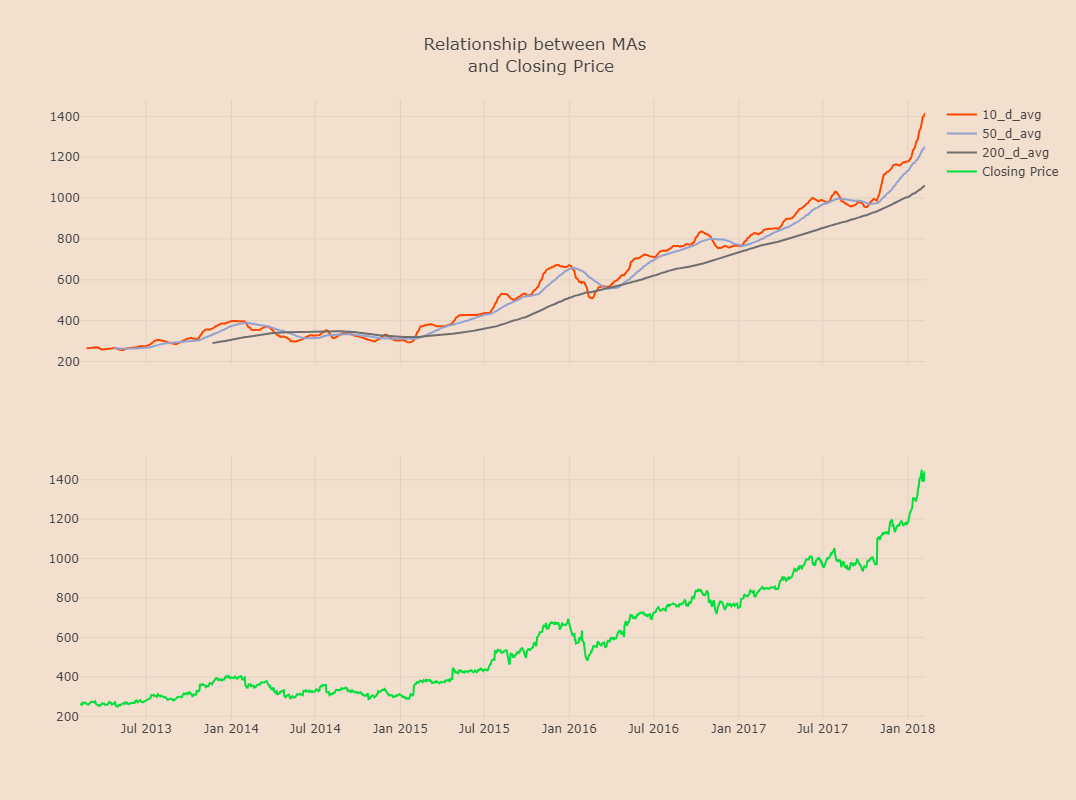

In [23]:
fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)

colors = ['#ff4500', '#92a1cf', '#6E6E6E']
avgs = ['10_d_avg', '50_d_avg', '200_d_avg']
# for i,c in zip(range(n),color):
#    ax1.plot(x, y,c=c)

for col, c in zip(avgs, colors):
    fig.append_trace({'x': amzn_df.index, 'y': amzn_df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}}, 1, 1)
for col in ['close']:
    fig.append_trace({'x': amzn_df.index, 'y': amzn_df[col], 'type': 'scatter', 'name': 'Closing Price', 'line':{'color': '#01DF3A'}}, 2, 1)
    
fig['layout'].update(height=800,title='Relationship between MAs <br> and Closing Price',
                    paper_bgcolor='#F2DFCE', plot_bgcolor='#F2DFCE')
    
iplot(fig, filename='pandas/mixed-type subplots')

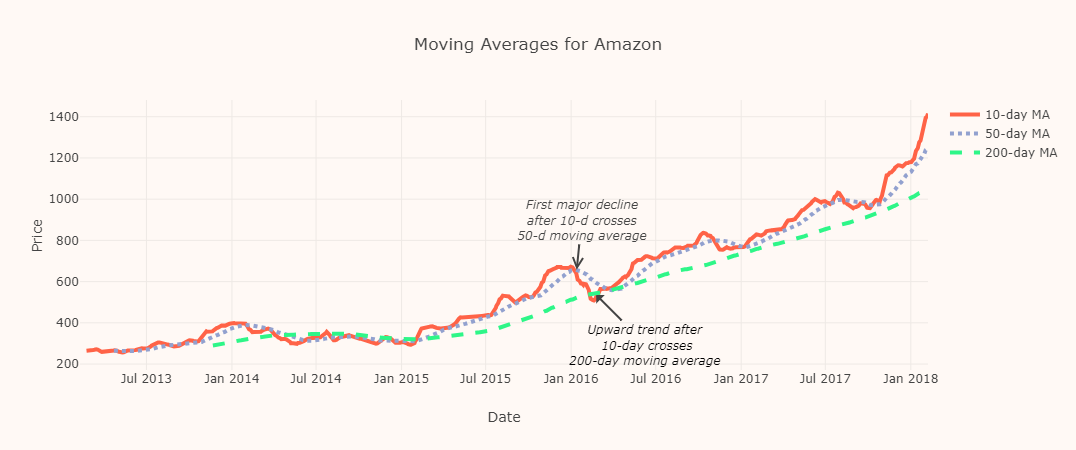

In [24]:
# Take off the date index
amzn_df = amzn_df.reset_index()

# Plotly
trace0 = go.Scatter(
    x = amzn_df['date'],
    y = ten_d,
    name = '10-day MA',
    line = dict(
        color = ('#ff6347'),
        width = 4)
)
trace1 = go.Scatter(
    x = amzn_df['date'],
    y = fifty_d,
    name = '50-day MA',
    line = dict(
        color = ('#92a1cf'),
        width = 4,
    dash="dot")
)
trace2 = go.Scatter(
    x = amzn_df['date'],
    y = twoh_d,
    name = '200-day MA',
    line = dict(
        color = ('#2EF688'),
        width = 4,
        dash = 'dash') # dash options include 'dash', 'dot', and 'dashdot'
)

data = [trace0, trace1, trace2]


# Edit the layout
layout = dict(title = 'Moving Averages for Amazon',
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Price'),
              annotations=[
        dict(
            x='2016-01-13',
            y=657,
            xref='x',
            yref='y',
            text='<i> First major decline <br> after 10-d crosses <br> 50-d moving average </i>',
            showarrow=True,
            arrowhead=5,
            ax=5,
            ay=-50
        ), dict(
        x = "2016-02-24",
        y = 535,
        text = "<i>Upward trend after <br> 10-day crosses <br>200-day moving average </i>",
        textangle = 0,
        ax = 50,
        ay = 50,
        font = dict(
          color = "black",
          size = 12
        )
        )],
              paper_bgcolor='#FFF9F5',
              plot_bgcolor='#FFF9F5'
              )

fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')

<h2> Stocks more Susceptible to Seasonality Trends: </h2>
In this section I want to show some types of stocks that are more vulnerable to seasonality such as airlines, hotel chains or cruiseships. In this example I will use American Airlines to demonstrate how a certain extent of the stock is influenced by seasonality movements.

<h3>Summary: </h3>
<ul>
    <li>December and January tends to be the months were there are more upward trends for the stock. </li>
    <li>July as well but not as much as December and January. </li>
    <li>September tends to be the month with the most downward pressure. </li>
    </ul>


In [25]:
# American Airlines
aal_df = df.loc[df["Ticks"] == "AAL"]

aal_df.loc[:, 'date'] = pd.to_datetime(aal_df.loc[:,'date'], format="%Y/%m/%d")

aal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 1258
Data columns (total 7 columns):
date      1259 non-null datetime64[ns]
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
close     1259 non-null float64
volume    1259 non-null int64
Ticks     1259 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 78.7+ KB


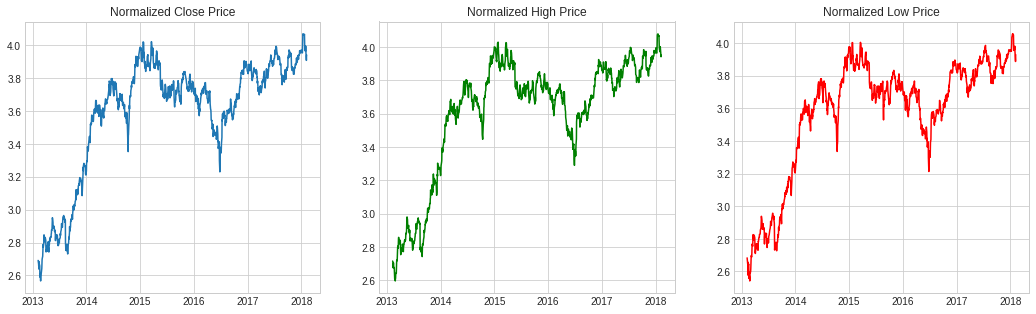

In [26]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

aal_df["close_log"] = np.log(aal_df["close"])
aal_df["high_log"] = np.log(aal_df["high"])
aal_df["low_log"] = np.log(aal_df["low"])

ax1.plot(aal_df["date"], aal_df["close_log"])
ax1.set_title("Normalized Close Price")
ax2.plot(aal_df["date"], aal_df["high_log"], color="g")
ax2.set_title("Normalized High Price")
ax3.plot(aal_df["date"], aal_df["low_log"], color="r")
ax3.set_title("Normalized Low Price")
plt.show()

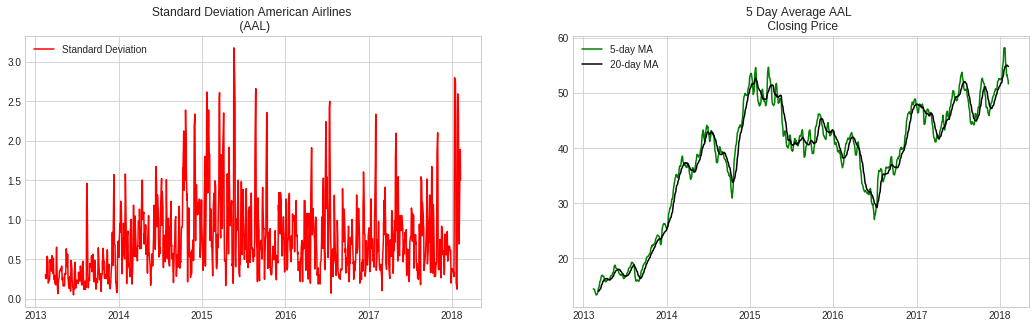

In [27]:
aal_df['std_close'] = aal_df["close"].rolling(5).std()
aal_df['mean_close'] = aal_df["close"].rolling(5).mean()
aal_df['twenty_mean_close'] = aal_df["close"].rolling(20).mean()

f, (std_ax, avg_ax) = plt.subplots(1, 2, figsize=(18,5))

std_ax.plot(aal_df["date"], aal_df["std_close"], color="r", label="Standard Deviation")
std_ax.legend(loc="upper left")
std_ax.set_title("Standard Deviation American Airlines \n (AAL)")

avg_ax.plot(aal_df["date"], aal_df["mean_close"], color="g", label="5-day MA")
avg_ax.plot(aal_df["date"], aal_df["twenty_mean_close"], color="k", label="20-day MA")
avg_ax.legend(loc="upper left")
avg_ax.set_title("5 Day Average AAL \n Closing Price")
plt.show()

In [28]:
m = Prophet()

# Drop the columns
ph_df = aal_df.drop(['open', 'high', 'low','volume', 'Ticks', 'close_log', 'high_log', 'mean_close', 'twenty_mean_close', 'low_log', 'std_close'], axis=1)
ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

ph_df.head()



,ds,y
0,2013-02-08,14.75
1,2013-02-11,14.46
2,2013-02-12,14.27
3,2013-02-13,14.66
4,2013-02-14,13.99


In [29]:
m.fit(ph_df)

future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1619,2019-02-03,64.312475,56.624106,72.375380
1620,2019-02-04,62.517533,54.721098,70.930033
1621,2019-02-05,62.510965,54.835848,71.008764
1622,2019-02-06,62.555272,54.911199,70.953923
1623,2019-02-07,62.535825,54.386744,71.091605


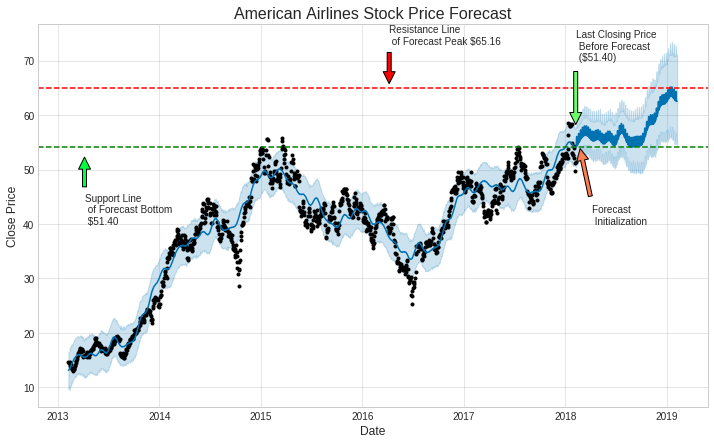

In [30]:
# Dates
starting_date = dt.datetime(2018, 4, 7)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2018, 2, 7)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 2, 18)
pointing_arrow1 = mdates.date2num(pointing_arrow)

# Dates Forecasting Resistance Line
resistance_date = dt.datetime(2016, 4, 7)
resistance_date1 = mdates.date2num(resistance_date)

# Dates Forecasting Support Line
support_date = dt.datetime(2013, 4, 7)
support_date1 = mdates.date2num(support_date)

# Learn more Prophet tomorrow and plot the forecast for amazon.
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("American Airlines Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

# Forecast initialization arrow
ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 55), xytext=(starting_date1,40),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

# # Trend emphasis arrow
ax1.annotate('Last Closing Price \n Before Forecast \n ($51.40)', xy=(trend_date1, 57), xytext=(trend_date1,70),
            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
            )

# Resistance Line
ax1.annotate('Resistance Line \n of Forecast Peak ${:.2f}'.format(forecast["yhat"].max()), xy=(resistance_date1, 65), xytext=(resistance_date1,73),
            arrowprops=dict(facecolor='#FF0000', shrink=0.1),
            )

# Support Line
ax1.annotate('Support Line \n of Forecast Bottom \n $51.40', xy=(support_date1, 53), xytext=(support_date1,40),
            arrowprops=dict(facecolor='#00FF40', shrink=0.1),
            )

ax1.axhline(y=65, color='r', linestyle='--')
ax1.axhline(y=54.2, color='g', linestyle='--')

plt.show()

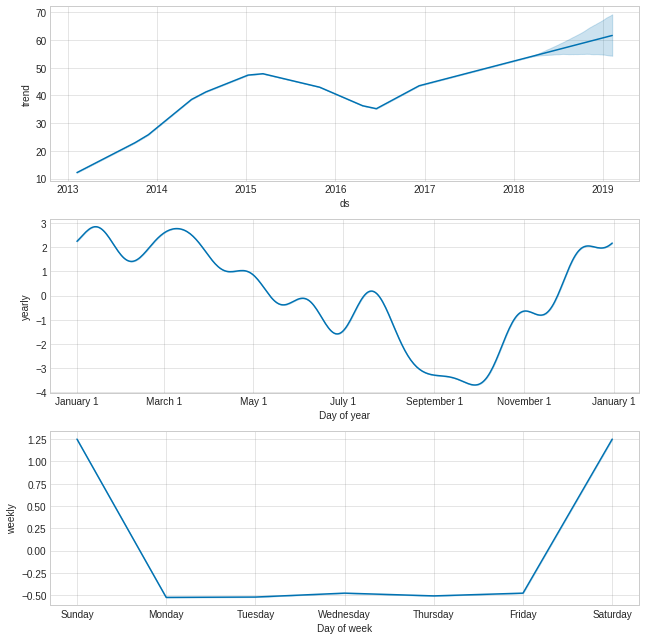

In [31]:
fig2 = m.plot_components(forecast)
plt.show()

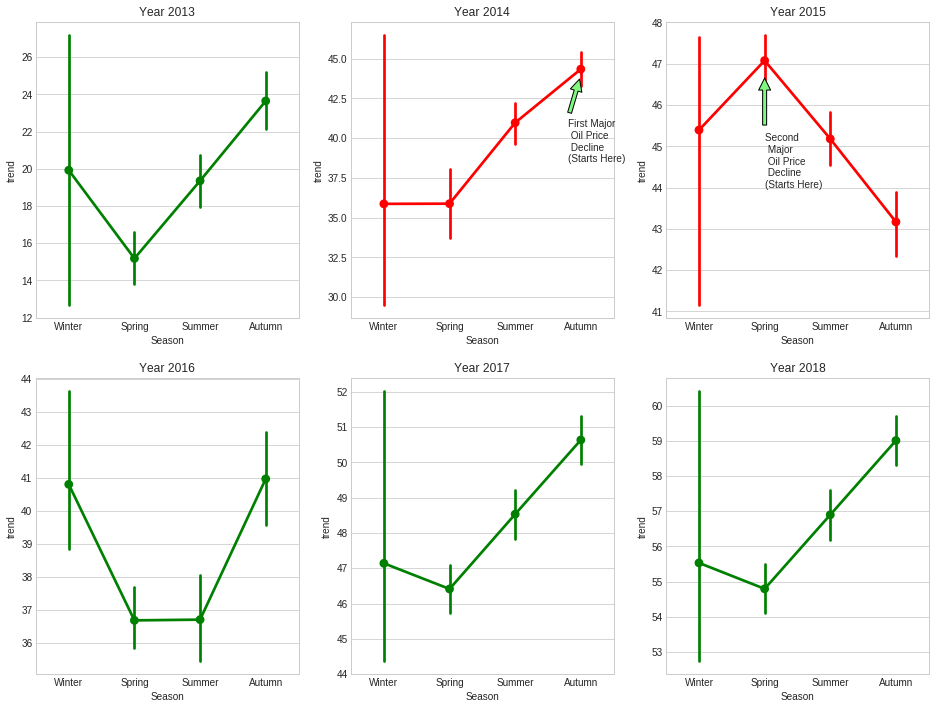

In [32]:
# Change dates from daily frequency to monthly frequency
forecast_monthly = forecast.resample('M', on='ds').mean()
forecast_monthly = forecast_monthly.reset_index() 


# Extract Year and Month and put it in a column.
forecast_monthly["month_int"] = forecast_monthly['ds'].dt.month
forecast_monthly["year"] = forecast_monthly['ds'].dt.year

forecast_monthly["month"] = np.nan
lst = [forecast_monthly]


for column in lst:
    column.loc[column["month_int"] == 1, "month"] = "January"
    column.loc[column["month_int"] == 2, "month"] = "February"
    column.loc[column["month_int"] == 3, "month"] = "March"
    column.loc[column["month_int"] == 4, "month"] = "April"
    column.loc[column["month_int"] == 5, "month"] = "May"
    column.loc[column["month_int"] == 6, "month"] = "June"
    column.loc[column["month_int"] == 7, "month"] = "July"
    column.loc[column["month_int"] == 8, "month"] = "August"
    column.loc[column["month_int"] == 9, "month"] = "September"
    column.loc[column["month_int"] == 10, "month"] = "October"
    column.loc[column["month_int"] == 11, "month"] = "November"
    column.loc[column["month_int"] == 12, "month"] = "December"
    
    
forecast_monthly['season'] = np.nan
lst2 = [forecast_monthly]

for column in lst2:
    column.loc[(column['month_int'] > 2) & (column['month_int'] <= 5), 'Season'] = 'Spring'
    column.loc[(column['month_int'] > 5) & (column['month_int'] <= 8), 'Season'] = 'Summer'
    column.loc[(column['month_int'] > 8) & (column['month_int'] <= 11), 'Season'] = 'Autumn'
    column.loc[column['month_int'] <= 2, 'Season'] = 'Winter'
    column.loc[column['month_int'] == 12, 'Season'] = 'Winter'
    
    

    

# Let's Create Seasonality Columns (Barplots that descripe the average trend per Season for each year)
# Create different axes by Year
df_2013 = forecast_monthly.loc[(forecast_monthly["year"] == 2013)]
df_2014 = forecast_monthly.loc[(forecast_monthly["year"] == 2014)]
df_2015 = forecast_monthly.loc[(forecast_monthly["year"] == 2015)]
df_2016 = forecast_monthly.loc[(forecast_monthly["year"] == 2016)]
df_2017 = forecast_monthly.loc[(forecast_monthly["year"] == 2017)]
df_2018 = forecast_monthly.loc[(forecast_monthly["year"] == 2018)]


f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16,12))


# Year 2013
sns.pointplot(x="Season", y="trend",
                    data=df_2013, ax=ax1, color="g")

# Year 2014
sns.pointplot(x="Season", y="trend",
                    data=df_2014, ax=ax2, color="r")

# Year 2015
sns.pointplot(x="Season", y="trend",
                    data=df_2015, ax=ax3, color="r")


# Year 2016
sns.pointplot(x="Season", y="trend",
                    data=df_2016, ax=ax4, color="g")

# Year 2017
sns.pointplot(x="Season", y="trend",
                    data=df_2017, ax=ax5, color="g")

# Year 2018
sns.pointplot(x="Season", y="trend",
                    data=df_2018, ax=ax6, color="g")

ax1.set_title("Year 2013")
ax2.set_title("Year 2014")
ax3.set_title("Year 2015")
ax4.set_title("Year 2016")
ax5.set_title("Year 2017")
ax6.set_title("Year 2018")

# Oil dips
# September 2014 and June 2015
ax2.annotate('First Major \n Oil Price \n Decline \n(Starts Here)', xy=(3, 44), xytext=(2.8,38.5),
            arrowprops=dict(facecolor='#81F781', shrink=0.1),
            )


ax3.annotate('Second \n Major \n Oil Price \n Decline \n(Starts Here)', xy=(1, 46.8), xytext=(1,44),
            arrowprops=dict(facecolor='#81F781', shrink=0.1),
            )

plt.show()

<h3>References: </h3>
<a src="https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series"> Everything you can do with a time series </a> by Siddharth Yadav 
- A special thanks to Siddharth for publishing an amazing work in the Kaggle community. Definitely, will recommend his work for anyone interested in Time Series Forecasting.